In [1]:
import os
import scipy.io
import numpy as np
import statistics, math
import matplotlib.pyplot as plt
from libs import util_matlab as umatlab
from libs import datasets, dataset_utils, utils
import tensorflow as tf
import datetime

In [2]:
data_dir="/Users/alfonso/matlab/IndirectAcquisition/keras/dataforMarius/export"
files = [os.path.join(data_dir, file_i) for file_i in os.listdir(data_dir) if file_i.endswith('.mat')]

In [3]:
# We'll tell matplotlib to inline any drawn figures like so:
%matplotlib inline
plt.style.use('ggplot')

In [4]:
matlabStruct=umatlab.loadmat(files[1]).get('data')
energyBand=matlabStruct.get('energyBand')
energyBand=(energyBand /120 )+1 #normalize [0-1]
residualEnergyBand=matlabStruct.get('residualEnergyBand')
residualEnergyBand=(residualEnergyBand /120 )+1 #normalize [0-1]

totalSecs=matlabStruct.get('waveIn').shape[0]/matlabStruct.get('audioSR')
energyBands_sr=energyBand.shape[1]/totalSecs #This is around 100Hz-10ms
controlNames=matlabStruct.get('controlNames')
controlData=matlabStruct.get('controlData')
string=controlData[0,:]
#pitch=controlData[6,:]/1500
    
# We want 500? milliseconds of audio in our window
winLSecs=0.05
windowSize=int((winLSecs*energyBands_sr)//2*2)
# And we'll move our window by 250 ms at a time
hopSize=windowSize//2
n_hops = (energyBand.shape[1]) // hopSize
windowSize

12

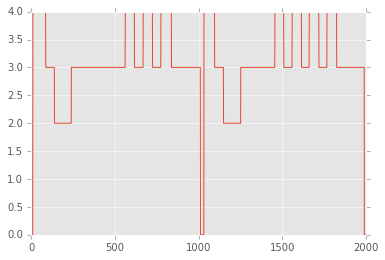

In [5]:
plt.plot(string)

In [8]:
joinWithPitch = 0

Xs = []
ys = []

# Let's start with the music files
for filename in files:
    #print(filename)
    matlabStruct=umatlab.loadmat(filename).get('data')
    energy_bands_dB = matlabStruct.get('energyBand')
    energy_bands = 10**(energy_bands_dB/20)
    rmsEnergy_dB=20*np.log10(np.sqrt(np.mean(energy_bands**2,0)))
    energy_bands_norm= energy_bands_dB / rmsEnergy_dB
    energy_bands_norm = energy_bands_norm /4
    energyBand = energy_bands_norm
    
    residualEnergyBand=matlabStruct.get('residualEnergyBand')
    residualEnergyBand=(residualEnergyBand /120 )+1 #normalize [0-1]
    controlData=matlabStruct.get('controlData')
    controlNames=matlabStruct.get('controlNames')
    string=controlData[0,:]
    pitch=controlData[6,:]/1500
    #wave=matlabStruct.get('wave')
    
    n_hops = (energyBand.shape[1]) // hopSize
    
    #print(n_frames_per_second, n_frames, frame_hops, n_hops)
    n_hops=int(n_hops)-1
    for hop_i in range(n_hops):
        # Creating our sliding window
        frames = energyBand[:,(hop_i * hopSize):(hop_i * hopSize + windowSize)]
        #frames= np.vstack((frames, residualEnergyBand[:,(hop_i * hopSize):(hop_i * hopSize + windowSize)]))
        if (joinWithPitch):
            #frame=np.append(frame, pitch[iframe])
            pitchframe=pitch[(hop_i * hopSize):(hop_i * hopSize + windowSize)]
            frames=np.vstack([frames, pitchframe])
        if(math.isnan(max(frames[:,1]))==False):
            avgString=round(statistics.median(string[(hop_i * hopSize):(hop_i * hopSize + windowSize)]))
            # Store them with a new 3rd axis and as a logarithmic scale
            # We'll ensure that we aren't taking a log of 0 just by adding
            # a small value, also known as epsilon.

            if (avgString-string[hop_i * hopSize]==0): #take only windows in the same string
                Xs.append(frames[..., np.newaxis])
                    # And then store the label 
                ys.append(int(avgString))
        #else:
            #print('warning: nan in frame ', hop_i)
Xs = np.array(Xs)
ys = np.array(ys)
print(Xs.shape, ys.shape)

(92523, 40, 12, 1) (92523,)


In [10]:
n_observations, feature_size, time_context, n_channels = Xs.shape
if joinWithPitch:
    feature_size = feature_size -1

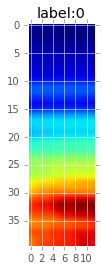

In [8]:
plt.imshow(Xs[5][..., 0])
plt.title('label:{}'.format(ys[0]))

In [11]:
n_classes=5
ds = datasets.Dataset(Xs=Xs, ys=ys, split=[0.8, 0.1, 0.1], one_hot=True, n_classes=n_classes)

In [12]:
Xs_i, ys_i = next(ds.train.next_batch())

# Notice the shape this returns.  This will become the shape of our input and output of the network:
print(Xs_i.shape, ys_i.shape)

(100, 40, 12, 1) (100, 5)


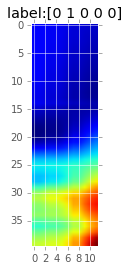

In [11]:
plt.imshow(Xs_i[0, :, :, 0])
plt.title('label:{}'.format(ys_i[0,...]))

Let's now create our deep convolutional network.  Start by first creating the convolutional layers.  Try different numbers of layers, different numbers of filters per layer, different activation functions, and varying the parameters to get the best training/validation score when training below.  Try first using a kernel size of `3` and a stride of `1`.  You can use the `utils.conv2d` function to help you create the convolution.

In [13]:
tf.reset_default_graph()
# Create the input to the network.  This is a 4-dimensional tensor!
# Recall that we are using sliding windows of our magnitudes (TODO):
X = tf.placeholder(name='X', shape=(None,feature_size,Xs.shape[2],Xs.shape[3]), dtype=tf.float32)

# Create the output to the network.  This is our one hot encoding of 2 possible values (TODO)!
Y = tf.placeholder(name='Y', shape=(None,n_classes), dtype=tf.float32)

if (joinWithPitch):
    X_pitch = tf.placeholder(name='X_pitch', shape=(None,1), dtype=tf.float32)
    
    
# TODO:  Explore different numbers of layers, and sizes of the network
n_filters = [30, 30, 30, 30, 30] # 20, 20
filters_height = [2, 2, 2, 2, 3] #[feature_size, 1]
filters_width = [2, 2, 2, 2, 1] #[1, time_context]
filters_stride_h = [2, 2, 2, 2, 2]#[feature_size, 1]
filters_stride_w = [2, 2, 2, 2, 2] #[1, 1]

# Now let's loop over our n_filters and create the deep convolutional neural network
H = X
for layer_i, n_filters_i in enumerate(n_filters):
    
    # Let's use the helper function to create our connection to the next layer:
    # TODO: explore changing the parameters here:
    H, W = utils.conv2d(
        H, n_filters_i, k_h=filters_height[layer_i], k_w=filters_width[layer_i],
        d_h=filters_stride_h[layer_i], d_w=filters_stride_w[layer_i],
        name=str(layer_i))
    
    # And use a nonlinearity
    # TODO: explore changing the activation here:
    H = tf.nn.softplus(H)
    
    # Just to check what's happening:
    print(H.get_shape().as_list())

[None, 20, 6, 30]
[None, 10, 3, 30]
[None, 5, 2, 30]
[None, 3, 1, 30]
[None, 2, 1, 30]


We'll now connect our last convolutional layer to a fully connected layer of 100 neurons.  This is essentially combining the spatial information, thus losing the spatial information.  You can use the `utils.linear` function to do this, which will internally also reshape the 4-d tensor to a 2-d tensor so that it can be connected to a fully-connected layer (i.e. perform a matrix multiplication).

In [14]:
# Connect the last convolutional layer to a fully connected network
fc, W = utils.linear(H, n_output=100, name="fcn1", activation=tf.nn.relu)
#fc2, W = utils.linear(fc, n_output=50, name="fcn2", activation=tf.nn.relu)
#fc3, W = utils.linear(fc2, n_output=10, name="fcn3", activation=tf.nn.relu)

# And another fully connceted network, now with just n_classes outputs, the number of outputs that our
# one hot encoding has 
if (joinWithPitch):
    #join this branch with the pitch
    h, W = utils.linear(fc, n_classes, activation=tf.nn.softmax, name='prejoin')
    joint = tf.concat(1, [X_pitch, h])
    join1, W1 = utils.linear(joint, n_output=50, name="join1", activation=tf.nn.relu)
    join2, W2 = utils.linear(join1, n_output=50, name="join2", activation=tf.nn.relu)
    join3, W3 = utils.linear(join2, n_output=n_classes, name="join3", activation=tf.nn.relu)
    Y_pred, W4 = utils.linear(join3, n_classes, activation=tf.nn.softmax, name='pred')
else:
    Y_pred, W3 = utils.linear(fc, n_classes, activation=tf.nn.softmax, name='pred')

We'll now create our cost.  Unlike the MNIST network, we're going to use a binary cross entropy as we only have 2 possible classes.  You can use the `utils.binary_cross_entropy` function to help you with this.  Remember, the final cost measure the average loss of your batches.

In [15]:
#loss = utils.binary_cross_entropy(Y_pred, Y)
loss = tf.squared_difference(Y_pred,Y)
cost = tf.reduce_mean(tf.reduce_sum(loss, 1))

Just like in MNIST, we'll now also create a measure of accuracy by finding the prediction of our network.  This is just for us to monitor the training and is not used to optimize the weights of the network!  Look back to the MNIST network in the lecture if you are unsure of how this works (it is exactly the same):

In [16]:
predicted_y = tf.argmax(Y_pred,1)
actual_y = tf.argmax(Y,1)
correct_prediction = tf.equal(predicted_y, actual_y)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

We'll now create an optimizer and train our network:

In [17]:
learning_rate = 0.001
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

Train and Validate the network.

Risk of [overfitting](https://en.wikipedia.org/wiki/Overfitting). This is a very common problem that can be addressed by using less parameters, or enforcing regularization techniques which we didn't have a chance to cover (dropout, batch norm, l2, augmenting the dataset, and others).

For this dataset, if you notice that your validation set is performing worse than your training set, then you know you have overfit!  You should be able to easily get 97+% on the validation set within < 10 epochs.  If you've got great training performance, but poor validation performance, then you likely have "overfit" to the training dataset, and are unable to generalize to the validation set.  Try varying the network definition, number of filters/layers until you get 97+% on your validation set!

In [18]:
# Create a session and init!
sess = tf.Session()
saver = tf.train.Saver()
sess.run(tf.initialize_all_variables())

In [19]:
# parameters
n_epochs = 50
batch_size = 100


# Now iterate over our dataset n_epoch times
for epoch_i in range(n_epochs):
    print('Epoch: ', epoch_i)
    
    # Train
    this_accuracy = 0
    its = 0
    accByString=[0]*5
    
    # Do our mini batches:
    batch_accuracy = 0
    for Xs_i, ys_i in ds.train.next_batch(batch_size):
        # Note here: we are running the optimizer so
        # that the network parameters train!
        if (joinWithPitch):
            [batch_prediction, batch_accuracy, _] = sess.run([Y_pred, accuracy, optimizer], feed_dict={
                X:Xs_i[:,0:-1], Y:ys_i, X_pitch:Xs_i[:,-1:,0,0]})
            this_accuracy += batch_accuracy
            #compute accuracy for each string
            origString = np.argmax(ys_i,1)
            predString= np.argmax(batch_prediction,1)
            for iString in range(5):
                idx = np.where(origString==iString)
                if len(idx):
                    accByString[iString]+=np.average(np.equal(origString[idx],predString[idx]).astype(float))
        else:
            [batch_prediction, batch_accuracy, _] =  sess.run([Y_pred, accuracy, optimizer], feed_dict={
                X:Xs_i, Y:ys_i})
            this_accuracy += batch_accuracy
            #compute accuracy for each string
            origString = np.argmax(ys_i,1)
            predString= np.argmax(batch_prediction,1)
            for iString in range(5):
                idx = np.where(origString==iString)
                if len(idx):
                    accByString[iString]+=np.average(np.equal(origString[idx],predString[idx]).astype(float))
            
        its += 1
        #print(this_accuracy / its)
    print('Training accuracy: ', this_accuracy / its, '. Batch_accuracy: ', batch_accuracy)
    for iString in range(5):
        print("accByString[", iString, "]:", accByString[iString]/its)
    # Validation (see how the network does on unseen data).
    this_accuracy = 0
    its = 0
    
    # Do our mini batches:
    for Xs_i, ys_i in ds.valid.next_batch(batch_size):
        # Note here: we are NOT running the optimizer!
        # we only measure the accuracy!
        if (joinWithPitch):
            this_accuracy += sess.run(accuracy, feed_dict={
                X:Xs_i[:,0:-1], Y:ys_i, X_pitch:Xs_i[:,-1:,0,0]})
        else:
            this_accuracy += sess.run(accuracy, feed_dict={
                X:Xs_i, Y:ys_i})

        its += 1
    print('Validation accuracy: ', this_accuracy / its)

Epoch:  0


/Users/alfonso/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


Training accuracy:  0.419593641813 . Batch_accuracy:  0.888889
accByString[ 0 ]: nan
accByString[ 1 ]: 0.767250886476
accByString[ 2 ]: 0.177543666824
accByString[ 3 ]: 0.376532908017
accByString[ 4 ]: 0.25321079323
Validation accuracy:  0.709156326068
Epoch:  1
Training accuracy:  0.757189983701 . Batch_accuracy:  0.777778
accByString[ 0 ]: nan
accByString[ 1 ]: 0.868142461671
accByString[ 2 ]: 0.611352364843
accByString[ 3 ]: 0.691597268706
accByString[ 4 ]: 0.895232569949
Validation accuracy:  0.784375515035
Epoch:  2
Training accuracy:  0.803660215878 . Batch_accuracy:  0.722222
accByString[ 0 ]: nan
accByString[ 1 ]: 0.903459535357
accByString[ 2 ]: 0.671541137174
accByString[ 3 ]: 0.752825032367
accByString[ 4 ]: 0.910131151399
Validation accuracy:  0.779371379524
Epoch:  3
Training accuracy:  0.832387162848 . Batch_accuracy:  0.888889
accByString[ 0 ]: nan
accByString[ 1 ]: 0.922295861515
accByString[ 2 ]: 0.713635200231
accByString[ 3 ]: 0.787862432709
accByString[ 4 ]: 0.92462

In [168]:
# Do our mini batches:
Xs_i, ys_i = next(ds.train.next_batch(400))

if (joinWithPitch):
    prediction = sess.run([Y_pred], feed_dict={X:Xs_i[:,0:-1], X_pitch:Xs_i[:,-1:,0,0]})[0]
else:
    prediction = sess.run([Y_pred], feed_dict={X:Xs_i})[0]

<IPython.core.display.Javascript object>


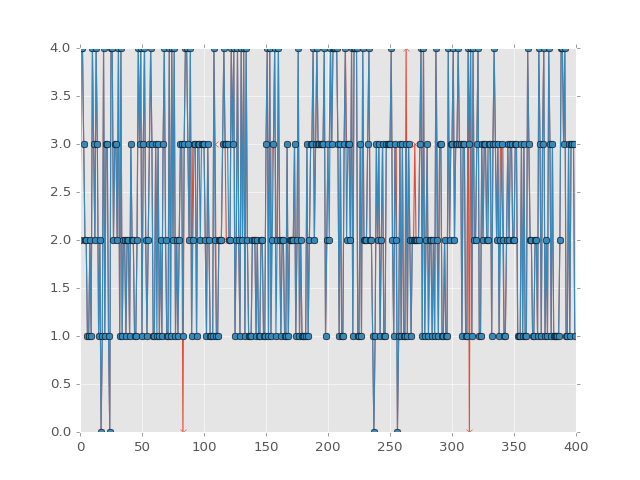

In [169]:
%matplotlib notebook
plt.plot(np.argmax(prediction,1),'x-')
plt.plot(np.argmax(ys_i,1),'o-')

In [ ]:
#save graph definition 
dst_nodes = ['Y']
graph_def = tf.python.graph_util.convert_variables_to_constants(
        sess, sess.graph_def, dst_nodes)

In [ ]:
g = tf.get_default_graph()
[op.name for op in g.get_operations()]

Now let's visualize the `W` tensor's weights for the first layer using the utils function `montage_filters` to inspect the performance of your network.  If many of the filters look uniform, then you know the network is either under or overperforming.  What you want to see are filters that look like they are responding to information such as edges or corners.

In [ ]:
g = tf.get_default_graph()
W = sess.run(g.get_tensor_by_name('1/W:0'))
W.shape

In [ ]:
assert(W.dtype == np.float32)
m = utils.montage_filters(W)
plt.figure(figsize=(5, 5))
plt.imshow(m)
plt.imsave(arr=m, fname='audio.png')

We can also look at every layer's filters using a loop:

In [ ]:
g = tf.get_default_graph()
for layer_i in range(len(n_filters)):
    W = sess.run(g.get_tensor_by_name('{}/W:0'.format(layer_i)))
    plt.figure(figsize=(5, 5))
    plt.imshow(utils.montage_filters(W))
    plt.title('Layer {}\'s Learned Convolution Kernels'.format(layer_i))

In [20]:
now = datetime.datetime.now()
save_path = saver.save(sess, "./models/string_convnet_yamahaDB_"+ now.strftime("%Y%m%d_%H%M") + ".ckpt")
print("Model saved in file: %s" % save_path)

Model saved in file: ./models/string_convnet_yamahaDB20170419_2309.ckpt


In [169]:
pitch.shape

(1431,)

In [170]:
scoreL=119
if (joinWithPitch):
    Xs_i=np.zeros(shape=(scoreL,41,windowSize,1))
    ys_i=np.zeros(shape=(scoreL))
    for i in range(scoreL):
        Xs_i[i,0:-1,:,0]=energyBand[:,i*windowSize:i*windowSize+windowSize]
        Xs_i[i,-1,:,0]=np.average(pitch[i*windowSize:i*windowSize+windowSize])
        ys_i[i]=round(statistics.median(string[i*windowSize:i*windowSize+windowSize]))
else:
    Xs_i=np.zeros(shape=(scoreL,40,windowSize,1))
    ys_i=np.zeros(shape=(scoreL))
    for i in range(scoreL):
        Xs_i[i,:,:,0]=energyBand[:,i*windowSize:i*windowSize+windowSize]
        #avgString=round(statistics.median(string[(hop_i * hopSize):(hop_i * hopSize + windowSize)]))
        ys_i[i]=round(statistics.median(string[i*windowSize:i*windowSize+windowSize]))
print("Xs_i.shape:", Xs_i.shape, ", ys_i.shape:", ys_i.shape)

Xs_i.shape: (119, 41, 12, 1) , ys_i.shape: (119,)


In [171]:
if (joinWithPitch):
    prediction = sess.run([predicted_y], feed_dict={X:Xs_i[:,0:-1], X_pitch:Xs_i[:,-1:,0,0]})[0]
else:
    #prediction = sess.run([Y_pred], feed_dict={X:Xs_i})[0]
    prediction=sess.run([predicted_y], feed_dict={X:Xs_i})[0] #, keep_prob: 1.0
#linPrediction = np.reshape(prediction, (np.product(prediction.shape)))
#linOriginal = np.reshape(ys_i, (np.product(ys_i.shape)))
#prediction.shape

<IPython.core.display.Javascript object>


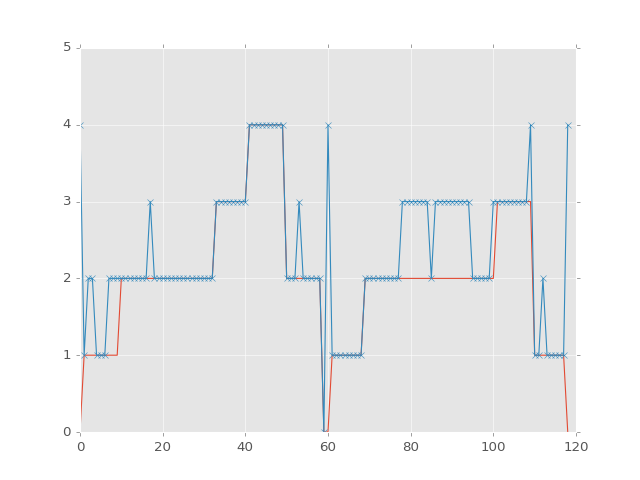

(0, 5)

In [176]:
%matplotlib notebook
plt.plot(ys_i)
plt.plot(prediction,'x-')
plt.ylim((0, 5))

In [174]:
plt.plot(ys_i)

In [135]:
prediction=sess.run([Y_pred], feed_dict={X:Xs_i})[0] #, keep_prob: 1.0 

In [137]:
prediction.shape

(119, 5)